<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/gc_20200315/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests,json
import datetime


In [0]:
covidtrackingurl = "https://covidtracking.com/api/v1/states/daily.json"
response = requests.get(covidtrackingurl)
dfCovidtracking = pd.DataFrame(response.json())
dfCovidtracking.fillna(0, inplace=True)
dfCovidtracking.negative = dfCovidtracking.negative.astype('int64')
dfCovidtracking.positive = dfCovidtracking.positive.astype('int64')
dfCovidtracking.pending = dfCovidtracking.pending.astype('int64')
dfCovidtracking.total = dfCovidtracking.total.astype('int64')
dfCovidtracking.death = dfCovidtracking.death.astype('int64')

dfCovidtracking.date = dfCovidtracking.date.transform(lambda x: pd.to_datetime(datetime.date(x//10000, x%10000//100, x%100
                                          )))


In [0]:
dfWHO = pd.read_csv("https://raw.githubusercontent.com/DMXMax/covid19/master/who/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
jhurl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"+\
"csse_covid_19_data/csse_covid_19_daily_reports/05-19-2020.csv"


dfJHUData = pd.read_csv(jhurl, header=0,
                        names=['FIPS', 'city','state', 'country', 'last_update',
                               'lat', 'lon','confirmed', 'dead', 'recovered','active', 'key'])

In [0]:
dfWHO = dfWHO.rename(columns={"Confirmed": "confirmed", "Deaths": "who_deaths"})
dfWHO.index.names=['date']


In [228]:
print("US Summary")
dfCovidtracking.groupby(by='date').sum()[-3:][['positive', 'death', 'positiveIncrease', 'deathIncrease']]

US Summary


,positive,death,positiveIncrease,deathIncrease
date,,,,
2020-05-17,1480158,83854,20737.0,839.0
2020-05-18,1499722,84640,19564.0,786.0
2020-05-19,1520778,86070,21056.0,1430.0


In [229]:
dfCovidtracking[dfCovidtracking.state=='CA'].head(5)

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
5,2020-05-19,CA,81795,1257521,0,4363.0,0.0,1307.0,0.0,0.0,0.0,0.0,B,5/19/2020 00:00,ad1044e4a2c384424aa492acbe2154e655566e10,2020-05-19T20:00:00Z,3334,0.0,1339316,1339316,1339316,06,32.0,0.0,45279.0,1365.0,46644.0
61,2020-05-18,CA,80430,1212242,0,4391.0,0.0,1325.0,0.0,0.0,0.0,0.0,B,5/17/2020 00:00,a4c726f97ca716cb19c945927806f45e0bb3cbea,2020-05-18T20:00:00Z,3302,0.0,1292672,1292672,1292672,06,41.0,0.0,55838.0,1591.0,57429.0
117,2020-05-17,CA,78839,1156404,0,4291.0,0.0,1293.0,0.0,0.0,0.0,0.0,B,5/17/2020 00:00,efe3d2e04569547fc50e7c3d8084f6f4ea4d4cc7,2020-05-17T20:00:00Z,3261,0.0,1235243,1235243,1235243,06,57.0,0.0,54071.0,2046.0,56117.0
173,2020-05-16,CA,76793,1102333,0,4424.0,0.0,1313.0,0.0,0.0,0.0,0.0,B,5/16/2020 00:00,e335473bcecc2092fc63063fe12ed043c5f73751,2020-05-16T20:00:00Z,3204,0.0,1179126,1179126,1179126,06,96.0,0.0,43363.0,1857.0,45220.0
229,2020-05-15,CA,74936,1058970,0,4519.0,0.0,1324.0,0.0,0.0,0.0,0.0,B,5/14/2020 00:00,dd4a56509207e53adc6f228223657494252d0d39,2020-05-15T20:00:00Z,3108,0.0,1133906,1133906,1133906,06,76.0,0.0,27483.0,1772.0,29255.0


In [0]:
dfctd_state_curr = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()] \
  .rename(columns={'positive':'total_positive'}) \
  .set_index('state') 

print(f"Total positive cases = {dfctd_state_curr.total_positive.sum()}")
print(f"Total deaths = {dfctd_state_curr.death.sum()}")
  
dfctd_state_curr.sort_values(by='total_positive', ascending=False).head(5)

In [0]:
curr_state = 'CA'
gbUSA = dfCovidtracking.groupby(['date'])
gbState = dfCovidtracking[dfCovidtracking.state==curr_state].groupby(['date'])

cols = ['positive', 'totalTestResults', 'death', 'positiveIncrease','deathIncrease']

dfUSAPos = gbUSA[cols].sum().reset_index().copy()
dfStatePos = gbState[cols].sum().reset_index().copy()

#This will calculate the percentage each day is of the total. In a flattening, this will be more even
# In a high growth situation, you'll higher percentages at the tail. 

dfUSAPos['pos_pct']= dfUSAPos.positive/dfctd_state_curr.total_positive.sum()
dfStatePos['pos_pct']=dfStatePos.positive/dfctd_state_curr.loc[curr_state].total_positive

In [0]:
dfUSAPos[-7:]


In [0]:
dfStatePos[-7:]

In [0]:
gbUSA.sum()[-5:]

In [0]:
gbState.sum()[-5:]

In [0]:
rn = gbState.sum().loc['2020-05-02']
rn.positive/rn.totalTestResults*100

In [0]:
x=gbUSA.sum().loc[:, ['positive', 'negative','death','total']].plot.line()

In [0]:
dfResults = gbUSA.sum().join(dfWHO, how='left', rsuffix='_who' )
dfResults.loc[:, ['positive', 'confirmed']].plot.line()

# John Hopkins Data


In [0]:
dfJHUData[dfJHUData.country=='US'][['confirmed', 'dead']].sum()

In [0]:
dfJHUData[(dfJHUData.country=='US')&(dfJHUData.state=='California')][['confirmed', 'dead']].sum()

In [0]:
dfJHUUS = dfJHUData[dfJHUData.country=='US']
gbJHUByState= dfJHUUS.groupby(by='state')
gbJHUByCountry = dfJHUData.groupby(by='country')

In [0]:
gbJHUByCountry.confirmed.sum().sort_values(ascending=False).head(10)

In [0]:
dfctd_state_curr.head()

In [0]:
dfState = dfCovidtracking[['date','state','positive', 'death']].set_index('state') \
  .join(dfctd_state_curr.total_positive)

In [0]:
dfState['pct']=dfState.positive/dfState.total_positive

In [0]:
dfState.loc['FL'].head(7)

In [0]:
res = dfState.reset_index().pivot(index = 'date', columns='state', values='pct').fillna(0)

In [0]:
x = res.loc[:, ['CA','FL']].plot.line()

In [0]:
dfNYTesting = dfCovidtracking.loc[dfCovidtracking.state=='NY', ['date', 'negative']].set_index('date')

In [0]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:].deathIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Deaths'],fontsize=32)


In [0]:
x = dfCovidtracking.groupby(by='date')
y1=x.sum()[-33:-3].positiveIncrease.plot.line(figsize=(40,20), fontsize=36, \
  style='.-', markersize=48, color='red', linewidth=4) \
.legend(['Daily Additional Positive Tests'],fontsize=32)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfByWeekYear = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=getWeek)


In [0]:
def getWeek(dt):
  return (dt.year*100)+dt.week

dfDoW = dfCovidtracking.set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']].groupby(by=lambda x: x.dayofweek)


In [0]:
dfDoW.mean().deathIncrease.plot.bar()



In [0]:
dfByWeekYear.sum()[-7:]

In [0]:
import matplotlib.ticker as ticker
plt1 = dfByWeekYear.sum()[:-1][['deathIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='red')
plt1.legend(['Weekly Additional Deaths'],fontsize=32)
plt2 = dfByWeekYear.sum()[:-1][['totalTestResultsIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='purple')
plt2.legend(['Weekly Additional Tests'],fontsize=32)

plt2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%6.0d'))
    
plt3 = dfByWeekYear.sum()[:-1][['positiveIncrease']].plot.line(figsize=(40,20), \
    fontsize=36, style='.-', markersize=48, linewidth=10, color='green')
plt3.legend(['Weekly Additional Postives'],fontsize=32)

In [0]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().positiveIncrease.plot.line()

In [0]:
dfCovidtracking.groupby(by='date').sum().rolling(window=7).mean().deathIncrease.plot.line()

In [0]:
dfCAAvg = dfCovidtracking[dfCovidtracking.state=='CA'] \
.groupby(by='date').sum().rolling(window=7).mean()

In [0]:

graph1 = dfCAAvg[20:].positiveIncrease.plot.bar(figsize=(14,7))


In [0]:
dfCAAvg.deathIncrease.plot.line()

In [0]:
dfDates = dfState.reset_index().copy()
dfDates[(dfDates.state.isin(['FL']))].head(10)

In [0]:
datecutoff = dfDates.date.max()-datetime.timedelta(days=7)
dfDates[(dfDates.date == datecutoff) & (dfDates.pct < .75)].sort_values(by='pct')


In [0]:
state = 'CA'
dfState = dfCovidtracking[dfCovidtracking.state==state].sort_values(by='date')
vals = dfState.positive.values

x=pd.Series([y-x for x,y in zip(vals,vals[1:])], \
          index = dfCovidtracking[dfCovidtracking.state==state]\
          .sort_values(by='date').date.values[1:] ) \
          .plot.bar(figsize=(12,5))



# State Population Data


In [0]:
data_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv"


In [0]:
dfUSPop = pd.read_csv(data_url)

In [0]:
import math
us_pop = dfUSPop.loc[0].POPESTIMATE2019 #Estimate from Wikipedia
res = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max(), ['positive', 'negative', 'pending','death', 'total']].sum()
cir = res.positive/res.total
cfr = res.death/res.positive
p_aff= math.ceil(us_pop*cir)
p_dead= math.ceil(p_aff*cfr)
print(res)
print(f"Current Infection Rate {cir*100:2f}%")
print(f"Percentage of US affected: {(res.positive+res.death)/us_pop*100:2f}%")
print(f"Observed CFR: {cfr*100:2f}%")
print(f"Percentage of US tested/affected: {(res.negative+res.positive+res.death)/us_pop*100:2f}%")
print(f"Projected affected by cir = {p_aff:,d}")
print(f"Projected killed = {p_dead:,d}")


In [0]:
!if [ ! -d "loc" ]; then \
git clone https://gist.github.com/rogerallen/1583593 --depth=1 --quiet loc; \
fi
import sys
sys.path.append("loc")




In [0]:
import us_state_abbrev as us_abbr


In [0]:
dfStatePop = dfUSPop[dfUSPop.STATE != 0].copy()

In [0]:
dfStatePop['ABBR']=dfStatePop.NAME.apply(lambda x: us_abbr.us_state_abbrev[x])

In [0]:
dfStatePop = dfStatePop.loc[:, ['ABBR', 'POPESTIMATE2019']]
dfStatePop.set_index('ABBR', inplace=True)

In [0]:
dfStateCovid = dfCovidtracking.loc[dfCovidtracking.date==dfCovidtracking.date.max()].set_index('state')

In [0]:
dfStateJoin = dfStateCovid.join(dfStatePop)

In [0]:
pd.DataFrame([(dfStateJoin.positive / dfStateJoin.POPESTIMATE2019)*100, \
              (dfStateJoin.totalTestResults/ dfStateJoin.POPESTIMATE2019)*100],\
             index=['state_pos_pop','state_test_pop'] ).T.sort_values(by="state_pos_pop", ascending=False)[:51]

In [0]:
#print(f"Current Infection Rate {res.positive/res.total*100:2f}%")

print(f"Current Testing Percent {gbUSA.sum().tail(1).totalTestResults[0]/dfUSPop[dfUSPop.REGION=='0'].POPESTIMATE2019[0]*100:2f}%")

In [0]:
dfJHUData.columns

In [0]:
dfOwid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [0]:
dfOwid.info()


In [0]:
dfOwidTests = dfOwid.dropna(subset=['total_tests']).copy()

In [0]:
dfOwidLatest = dfOwidTests.sort_values(by='date').groupby('iso_code').last()

In [0]:
dfOwidLatest.total_tests.sort_values(ascending=False)

In [0]:
isUSA = dfOwidLatest.index.isin(['USA'])
NonUSTests = dfOwidLatest[~isUSA].total_tests.sum()
USTests = dfOwidLatest[isUSA].total_tests.sum()

print(f"Total testing done outside of USA: {NonUSTests:.0f}")
print(f"Total tests done in USA : {USTests:.0f}")
print(f"How many more times has the world tested more than the US: {NonUSTests/USTests:.1f}")

In [0]:
dfOwidLatest[isUSA].sum()

In [0]:
dfOwidUSA = dfOwid.loc[dfOwid.iso_code=='USA']

dfOwidUSA.set_index('date')[['new_cases','new_deaths']][-7:]

In [0]:
state = 'MN'
dfRollingWeekState = dfCovidtracking.loc[dfCovidtracking.state==state].set_index('date')\
.rolling(window=7).sum()


In [0]:
plt = dfRollingWeekState.positiveIncrease.plot.line()

In [0]:
dfJHUData[dfJHUData.state=='Florida'].confirmed.sum()

In [0]:
doWGA = dfCovidtracking[dfCovidtracking.state=='GA'].set_index('date')[['deathIncrease', 'hospitalizedIncrease', 'negativeIncrease','positiveIncrease','totalTestResultsIncrease']]\
.groupby(lambda x: x.dayofweek)

In [0]:
doWGA.sum()

# Socrata (San Francisco) Data

In [0]:
!pip install sodapy

In [0]:
from sodapy import Socrata

In [0]:
client = Socrata("data.sfgov.org", "LCSuN5PrqWkGtBe9dULkS75Rz")
results_df = pd.DataFrame.from_records(client.get("tvq9-ec9w"))

In [240]:
results_df.case_disposition.unique()

array(['Confirmed', 'Death'], dtype=object)

In [0]:
res = results_df.astype({'case_count':'int16'})

In [0]:
dfresConf = res[res.case_disposition=='Confirmed']
dfresDead = res[res.case_disposition=='Death']

In [259]:
dfresDead.groupby('date').sum()

,case_count
date,
2020-03-17T00:00:00.000,1
2020-03-24T00:00:00.000,1
2020-03-26T00:00:00.000,3
2020-03-27T00:00:00.000,2
2020-03-30T00:00:00.000,1
2020-03-31T00:00:00.000,1
2020-04-01T00:00:00.000,3
2020-04-05T00:00:00.000,1
2020-04-06T00:00:00.000,1


In [256]:
dfresConf.groupby('date').sum().rename(columns={'case_count':'new_cases'}).tail()

,new_cases
date,
2020-05-13T00:00:00.000,41
2020-05-14T00:00:00.000,16
2020-05-15T00:00:00.000,33
2020-05-16T00:00:00.000,29
2020-05-17T00:00:00.000,29


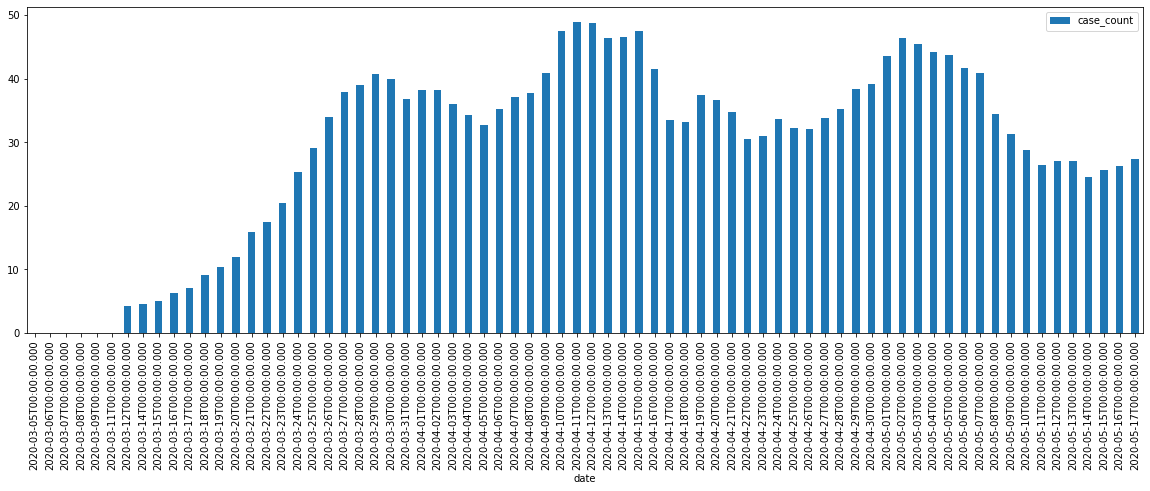

In [232]:
res.groupby('date').sum().rolling(window=7).mean().plot.bar(figsize=(20,6))

# Marin Data

In [0]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSRmO2pStf7Ft1yYjDULluZXzUAczGK_B34hDemDBadGEY0HTLwlcadF2cHNEwmmvLetUTf-D2ruYCT/pub?gid=0&single=true&output=csv"

df = pd.read_csv(url, header=1, parse_dates=[0], usecols=[0,1,3,5,6,7], index_col=[0])

In [0]:
df.tail()

In [0]:
df.positive - df.positive[1:]

In [0]:
df.positive.diff().rolling(window=7).mean().plot.bar(figsize=(14,5))

In [0]:
marin_pop = 252409

print(f"Marin Population Positive: {(df[-1:].positive[0]/marin_pop)*100:2.2f}%")
print(f"Marin Population Tested: {(df[-1:].tested[0]/marin_pop)*100:2.2f}%")

In [0]:
df.positive.diff().tail()

In [0]:
df.positive.diff().rolling(window=7).mean().tail()